# 不動産価格の単回帰

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pystan
%matplotlib inline

In [2]:
plt.style.use("ggplot")

In [3]:
df = pd.read_excel("./data/real_estate1.xlsx")

In [4]:
# id, space, room, value(予測する物件価格)

df.head()

,id,space,room,value
0,1,50,2LDK,3050
1,2,70,2LDK,4690
2,3,70,2SLDK,4830
3,4,70,3LDK,5040
4,5,90,3LDK,6570


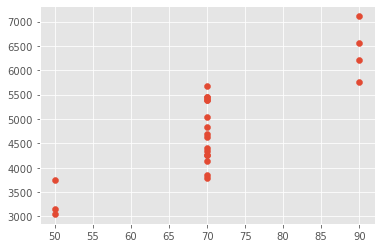

In [5]:
# 物件価格は部屋の大きさに正の相関あり=単回帰でモデリングできそう
# また物件価格のヒストグラムは正規分布と仮定

plt.scatter(df["space"],df["value"])

In [6]:
# PyStanは書き方が特殊
# コメントで以下のようなブロックを書く必要がある
# ①dataブロック（観測したデータの入れ物）→
# ②パラメータのブロック→
#  平均値が単回帰になる正規分布と仮定してるからパラメータは、傾き:a, 切片:b, 標準偏差:σ
# ③統計モデルの（尤度関数）ブロック→
# ④事前分布
#  省略している。事前分布していなければ無条件兼事前分布が事前分布になる

stan_model = """
data {
  int N;
  real X[N];
  real Y[N];
}

parameters {
  real a;
  real b;
  real<lower=0> sigma;
}

model {
  for (n in 1:N){
    Y[n] ~ normal(a * X[n] + b, sigma);
  }
}

"""

In [7]:
# PyStanはコンパイルが必要（C++でコンパイルされる）
# 結構時間かかる

sm = pystan.StanModel(model_code = stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1ef597a9137b242c406fc64a47bf328b NOW.


In [8]:
# dataブロックに入れるデータを辞書型で渡す

stan_data = {"N":df.shape[0], "X":df["space"],"Y":df["value"]}

In [9]:
# MCMCでサンプリング

fit = sm.sampling(data = stan_data, iter=2000, warmup=500, chains = 3, seed=123)

In [10]:
# 結果の抽出
# 事後分布の平均値や誤差が表示される
# Rhat<=1ならうまく収束している
# a=77.99なので、1平米上がると価格これぐらい上がる

fit

Inference for Stan model: anon_model_1ef597a9137b242c406fc64a47bf328b.
3 chains, each with iter=2000; warmup=500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=4500.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a      77.99    0.33  11.86  53.99   70.6  78.34  85.69 100.49   1277    1.0
b     -692.9   23.85 850.19  -2301  -1243 -718.7 -164.6 1068.0   1271    1.0
sigma 621.72    2.71 106.36 457.19 545.24 607.26 682.49  870.5   1539    1.0
lp__  -152.0    0.04   1.37 -155.5 -152.6 -151.7 -151.0 -150.5   1306    1.0

Samples were drawn using NUTS at Wed Sep 30 00:05:00 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

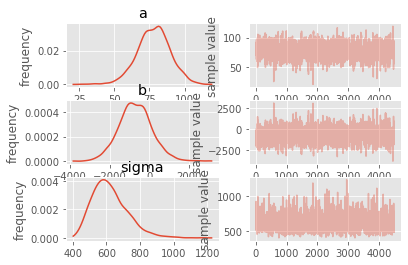

In [11]:
# 事後分布plot
# トレースプロットは横軸step縦軸サンプリングの値
# トレースプロットがまんべんなくplot（サンプリング）されているなら収束してる

fig = fit.plot()

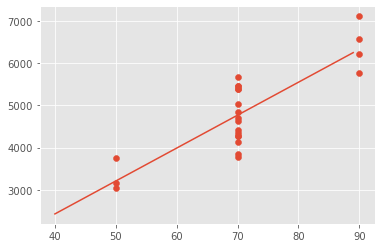

In [14]:
# 推定したパラメータで単回帰の式構築
# 正規分布を仮定しているから観測テータの平均の点を通るような式になってることがわかる

a = 77.99
b = -692.9
x = np.arange(40,90,1)
y = a * x + b
plt.plot(x,y)
plt.scatter(df["space"],df["value"])